### Imports
https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

%run plot.py

### Read data

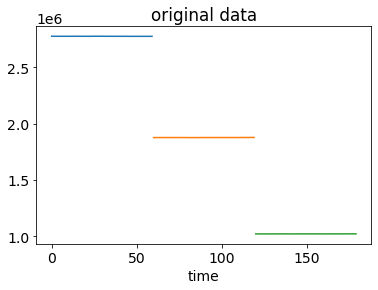

data:  20


In [21]:
#str0 = 'ts_L60_Z12_A500_DX50_bias5_N50.dat'
#fnamex='DATA/x_'+str0
#fnamey='DATA/y_'+str0
numb=6
str0 = f'data_gen_50_samples_X_{numb}.dat'
str1 = f'data_gen_50_samples_Y_{numb}.dat'

fnamex='Exercise4LabCompB-data/'+str0
fnamey='Exercise4LabCompB-data/'+str1

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

# note: here it does not need to be converted to the 3-bit version, a label remains y[i]=0,1,2
y = np.loadtxt(fnamey, dtype=float)
n_class = 3    #  = len(np.unique(y))
print('data: ',N)

### (do not) Rescale data
We know that the average value of a sample is not relevant: let's see if XGBoost works if we do not remove such average and we do not standardize data

In [22]:
RESCALE=False
if RESCALE:
    #remove average value of each sample from its values
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    #rescale (crude version, variance should be used)
    x = x/400

    Show_data(x,L,"rescaled data")

## TSFRESH: extract features

Input data format: DATAFRAME

first column $\to$ id of the sample 

second column $\to$  id of the time step

third column $\to$ value of the feature of _id_-sample at _id_-step

For more: https://tsfresh.readthedocs.io/en/latest/text/data_formats.html

In [23]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [24]:
#get df
df = get_df(x) 

#check that last columns, if reshaped is equal to x
#df_to_array = df.values[:,-1].reshape(x.shape[0],x.shape[1])
#sum of different values: should be 0
#print('Differences:',np.sum(df_to_array != x))

df

,id,time,value
0,0,0,2776958.0
1,0,1,2776953.0
2,0,2,2776962.0
3,0,3,2776875.0
4,0,4,2776935.0
...,...,...,...
1195,19,55,36058.0
1196,19,56,36022.0
1197,19,57,36109.0
1198,19,58,36166.0


In [25]:
#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 12.45it/s]


In [28]:
#look at x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98",value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,166605449.0,4.626229e+14,40.627119,-9.847458,0.439655,2776854.0,...,3.734467,3.814290,NaN,0.717909,3.180792,1.646048,1.882411,0.946901,2.119753,2.777123e+06
1,1.0,0.0,0.0,1.0,112602353.0,2.113215e+14,52.796610,15.237288,-0.275862,1876695.5,...,3.251498,3.526886,NaN,0.752400,4.078149,2.242620,2.067855,1.095299,3.390245,1.877272e+06
2,1.0,0.0,0.0,1.0,61210771.0,6.244598e+13,37.576271,8.016949,0.206897,1020148.0,...,3.856101,3.963312,NaN,0.900045,2.834451,1.798043,1.698784,1.270580,2.304533,1.020461e+06
3,1.0,0.0,0.0,1.0,56364748.0,5.294975e+13,57.864407,0.135593,1.594828,939377.5,...,3.821382,3.902278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.398301e+05
4,1.0,0.0,0.0,1.0,39499108.0,2.600299e+13,51.762712,10.338983,0.129310,658355.0,...,3.811869,3.963312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.586177e+05
5,1.0,0.0,0.0,1.0,98522620.0,1.617784e+14,49.508475,-4.694915,-0.405172,1641969.0,...,3.660636,3.778928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642511e+06
6,1.0,0.0,0.0,1.0,15089448.0,3.794859e+12,47.474576,4.898305,-0.810345,251488.0,...,3.736252,3.839962,NaN,0.881712,3.368586,2.241313,2.268469,1.985857,2.583600,2.518646e+05
7,1.0,0.0,0.0,1.0,24306822.0,9.847029e+12,41.610169,6.016949,-0.577586,405126.0,...,3.830896,3.988984,NaN,0.681848,3.176710,1.705336,1.732003,1.306159,2.081053,4.054620e+05
8,1.0,0.0,0.0,1.0,142208515.0,3.370544e+14,54.830508,0.593220,-0.224138,2370170.0,...,3.614618,3.773917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.370385e+06
9,1.0,0.0,0.0,1.0,13684054.0,3.120891e+12,45.254237,0.881356,0.836207,228136.5,...,3.821382,3.963312,NaN,0.713805,2.937239,1.806110,1.801171,1.466530,2.256965,2.282901e+05


In [8]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

In [9]:
#look at clean x_features
x_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,60109435.0,6.021907e+13,46.728814,-0.322034,0.215517,1001831.5,...,0.457102,0.936038,1.196951,2.774161,1.699191,2.750942,3.511559,3.956922,3.988984,1.001958e+06
1,1.0,0.0,0.0,1.0,81951066.0,1.119330e+14,47.440678,7.881356,0.077586,1365951.5,...,0.283936,0.283936,0.424254,0.838120,1.684535,2.768706,3.526971,3.931717,3.988984,1.366113e+06
2,1.0,0.0,0.0,1.0,83665690.0,1.166658e+14,39.576271,6.559322,0.301724,1394460.5,...,0.283936,0.518700,0.656671,1.874245,1.770895,2.864776,3.660091,3.881306,3.988984,1.394596e+06
3,1.0,0.0,0.0,1.0,149985074.0,3.749254e+14,43.711864,2.220339,-1.034483,2499745.5,...,0.239217,0.379535,0.563420,1.905027,1.751056,2.901300,3.619924,3.881306,3.963312,2.499901e+06
4,1.0,0.0,0.0,1.0,151438090.0,3.822249e+14,33.661017,7.796610,0.922414,2523956.0,...,0.379535,0.518700,0.793400,1.884401,1.596722,2.590580,3.367341,3.846587,3.988984,2.524153e+06
5,1.0,0.0,0.0,1.0,90402521.0,1.362103e+14,53.728814,-1.966102,0.603448,1506777.5,...,0.142506,0.283936,0.424254,0.701390,1.626980,2.412505,2.935775,3.299305,3.531359,1.506964e+06
6,1.0,0.0,0.0,1.0,72380945.0,8.731669e+13,41.677966,7.101695,-0.025862,1206315.5,...,0.379535,0.379535,0.611952,1.758037,1.703545,2.749447,3.412538,3.720561,3.876606,1.206593e+06
7,1.0,0.0,0.0,1.0,9251278.0,1.426440e+12,52.593220,9.508475,0.112069,154162.5,...,0.142506,0.283936,0.283936,0.928839,1.620866,2.627032,3.401440,3.745766,3.937640,1.546853e+05
8,1.0,0.0,0.0,1.0,77977679.0,1.013420e+14,42.661017,6.661017,0.629310,1299638.0,...,0.379535,0.473981,0.793400,2.170592,1.692892,2.787380,3.474184,3.679664,3.736736,1.299789e+06
9,1.0,0.0,0.0,1.0,22163885.0,8.187301e+12,50.322034,7.915254,1.534483,369314.5,...,0.142506,0.283936,0.424254,0.928839,1.710455,2.719870,3.397446,3.761458,3.886296,3.699390e+05


### Split train/val

In [10]:
#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
if True:
    average = np.mean(x_train,axis=0)
    x_train -= average
    x_val -= average

    std = np.std(x_train,axis=0)
    x_train /= std
    x_val /= std

N_train= 16   N_val= 4   n_class= 3


In [11]:
#look at x_train
x_train

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,NaN,NaN,NaN,NaN,-0.301179,-0.506588,-0.197948,-0.968900,0.184721,-0.301154,...,1.343158,2.924634,2.770939,2.230158,0.543188,0.493848,0.705777,1.370558,1.006308,-0.301469
1,NaN,NaN,NaN,NaN,0.199101,-0.077090,-0.084835,0.830419,-0.019991,0.199250,...,-0.284127,-1.057050,-0.923649,-0.942907,0.266569,0.623173,0.791747,1.223065,1.006308,0.199030
2,NaN,NaN,NaN,NaN,0.238375,-0.037783,-1.334466,0.540446,0.312666,0.238429,...,-0.284127,0.376401,0.187633,0.755246,1.896555,1.322549,1.534325,0.928079,1.006308,0.238177
3,NaN,NaN,NaN,NaN,1.757414,2.107134,-0.677332,-0.411260,-1.670484,1.757403,...,-0.704364,-0.473332,-0.258241,0.805695,1.522106,1.588443,1.310264,0.928079,0.822501,1.757318
4,NaN,NaN,NaN,NaN,1.790695,2.167759,-2.274382,0.811831,1.233871,1.790676,...,0.614238,0.376401,0.841395,0.771891,-1.390810,-0.673567,-0.098708,0.724916,1.006308,1.790650
5,NaN,NaN,NaN,NaN,0.392681,0.124539,0.914331,-1.329507,0.760474,0.392785,...,-1.613184,-1.057050,-0.923649,-1.166999,-0.819728,-1.969941,-2.506101,-2.477597,-2.270199,0.392617
6,NaN,NaN,NaN,NaN,-0.020101,-0.281535,-1.000513,0.659409,-0.173526,-0.020135,...,0.614238,-0.473332,-0.026188,0.564786,0.625370,0.482963,0.153411,-0.012550,0.201701,-0.020217
7,NaN,NaN,NaN,NaN,-1.466080,-0.994877,0.733889,1.187309,0.031187,-1.466091,...,-1.613184,-1.057050,-1.594568,-0.794223,-0.935112,-0.408205,0.091505,0.134943,0.638693,-1.465968
8,NaN,NaN,NaN,NaN,0.108091,-0.165051,-0.844309,0.562752,0.798858,0.108116,...,0.614238,0.103350,0.841395,1.240943,0.424301,0.759116,0.497290,-0.251866,-0.799738,0.107873
9,NaN,NaN,NaN,NaN,-1.170318,-0.938726,0.373004,0.837854,2.142282,-1.170411,...,-1.613184,-1.057050,-0.923649,-0.794223,0.755800,0.267647,0.069225,0.226766,0.271078,-1.170121


## XGB

In [12]:
# reproducibility
np.random.seed(12345)

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
          'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model = XGBClassifier(**params)

#fit
model.fit(x_train.values,y_train)

[18:55:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

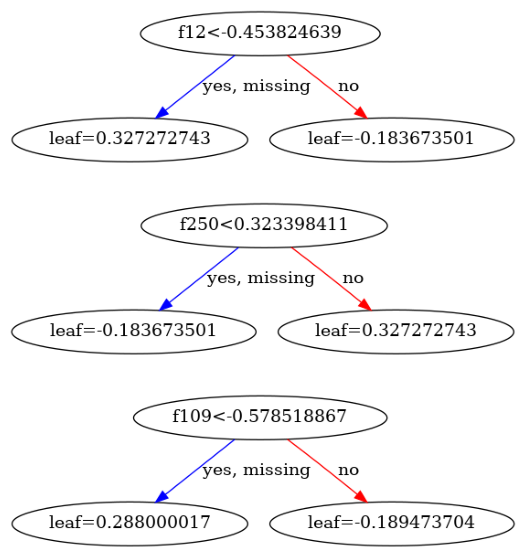

In [13]:
#plot tree

fig, AX = plt.subplots(3,1,figsize=(30, 10))
for i in range(3):
    ax=AX[i]
    plot_tree(model, num_trees=i, ax=ax)
    
fig.savefig("DATA/trees-time-ser.png", dpi=300, pad_inches=0.02)

In [14]:
from sklearn.metrics import accuracy_score

#predict labels on training set
y_pred_train = model.predict(x_train)
#predict labels on validation set
y_pred_val = model.predict(x_val)

y_pred_val_soft = model.predict_proba(x_val)



#compute accuracies
acc_train = accuracy_score(y_train,y_pred_train) 
acc_val = accuracy_score(y_val,y_pred_val)

#print accuracies
print('Training accuracy:',acc_train)
print('Validation accuracy:',acc_val)

Training accuracy: 1.0
Validation accuracy: 0.5


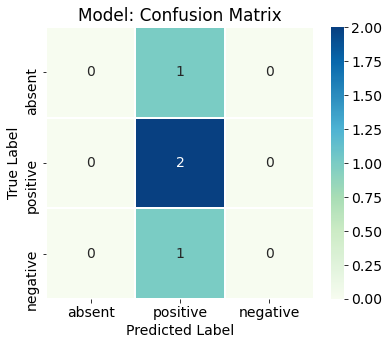

In [15]:
import seaborn as sns
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
show_confusion_matrix(y_val, y_pred_val)

### Feature importances

See an overview of extracted features:
https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [16]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

In [17]:
minval=0.005
print('------------- Feature importance sum = '+str(np.sum(model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])

------------- Feature importance sum = 1.0000001
------------- Showing feature with importance > 0.005
1 value__standard_deviation 0.3484931
2 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 0.3484931
3 value__partial_autocorrelation__lag_4 0.28344736
4 value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8 0.0066763093
5 value__longest_strike_below_mean 0.0065383026
6 value__fft_coefficient__attr_"real"__coeff_18 0.0063518747


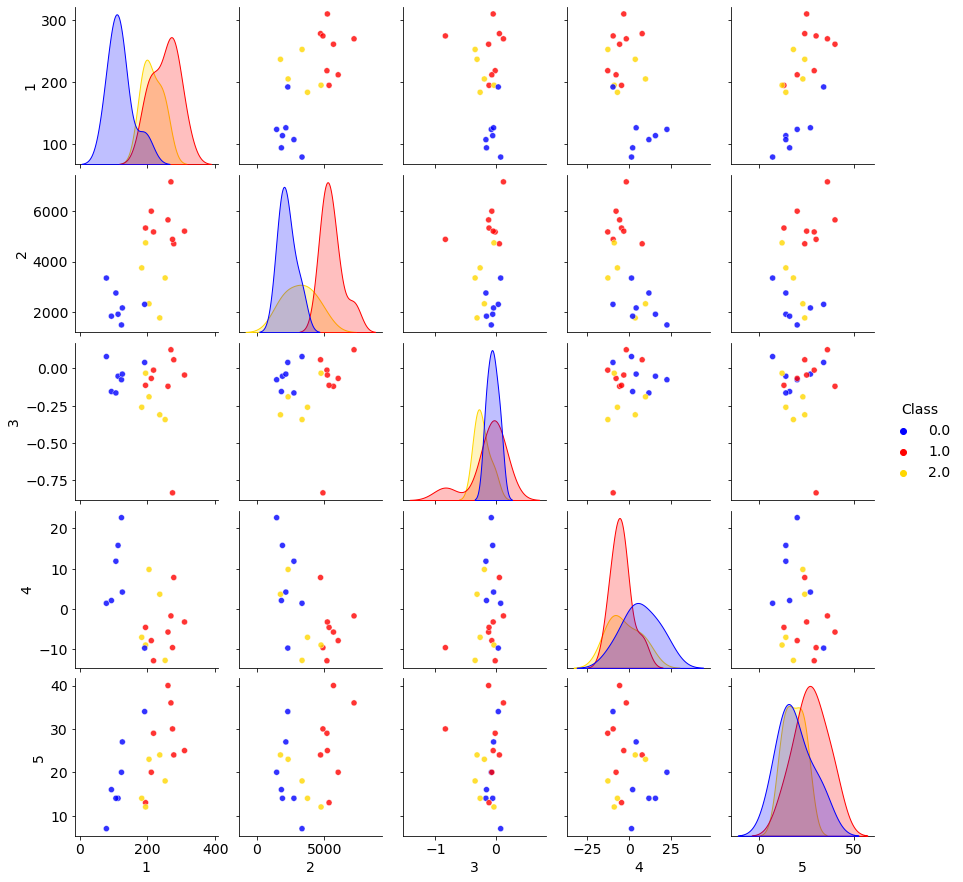

In [18]:
#get feature names given importance order
features = list(feat_imp.keys())

#build dataframe for sns pairplot
df = pd.DataFrame({'1':x_features[features[0]],\
                   '2':x_features[features[1]],\
                   '3':x_features[features[2]],\
                   '4':x_features[features[3]],\
                   '5':x_features[features[4]],\
                   'Class':y})
#pairplot with seaborn
pal = sns.blend_palette(["blue","red","gold"],n_class)
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);